Importing necessary libraries

In [1]:
!pip install -Uqq fastbook
import fastbook

     |████████████████████████████████| 727kB 25.6MB/s 
     |████████████████████████████████| 194kB 44.4MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 1.2MB 54.0MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 


In [2]:
from fastai.vision.all import *
from fastbook import *

Downloading the dataset from https://www.kaggle.com/andrewmvd/face-mask-detection'. This dataset consists of 853 images and their corresponding annotation files. Each annotation file contains the location of the faces and their label: 'with_mask',  'without_mask' or 'mask_weared_incorrect'

In [3]:
creds = '{"username":"surajgiri","key":"4ac020c2e0b9460dae4c2463c5f69a09"}'
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
from kaggle import api
api.dataset_download_files('andrewmvd/face-mask-detection', path='data', unzip=True)

Reading the images and annotations

In [5]:
path = Path('data')
images = (path/'images').ls().sorted()
annots = (path/'annotations').ls().sorted()

Reading data from annotations.xml files using bs4, using the data to crop faces from images and place them in folders according to their labels.

In [6]:
import numpy as np
import bs4, lxml
from PIL import Image

In [7]:
c=0

path = Path('Classified Images')
if not path.exists():
  path.mkdir()

for i in range(len(images)):

    with open(annots[i],'r') as f:
        data = f.read()

    soup = bs4.BeautifulSoup(data, 'xml')
    objects = soup.select('object')
    
    img = Image.open(images[i])
    imgArray = np.array(img)
    
    for j in range(len(objects)):
        xmin, ymin, xmax, ymax = [int(x) for x in soup.select('bndbox')[j].getText().split('\n')[1:-1]]
        label = soup.select('name')[j].getText()
        face = imgArray[ymin:ymax, xmin:xmax]
        face = Image.fromarray(face)
        
        dest = path/label
        dest.mkdir(exist_ok=True)
        imgName = 'img' + str(c) + '.png'
        face.save(dest/imgName)
        c+=1

Applying some transformations to the images and creating Dataloaders object for training our model

In [8]:
masks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                  get_items = get_image_files,
                 splitter = RandomSplitter(valid_pct=0.2),
                 get_y = parent_label,
                 item_tfms = RandomResizedCrop(224, min_scale=0.5),
                batch_tfms = aug_transforms())

In [14]:
dls = masks.dataloaders(path, bs=32)

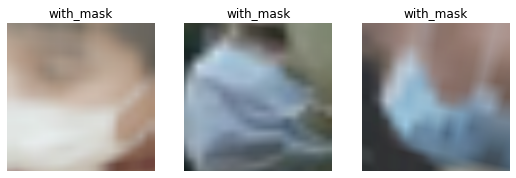

In [15]:
dls.train.show_batch(max_n=3)

In [16]:
X, y = dls.one_batch()
X.shape, y.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Saving our dataloaders object

In [17]:
save_pickle('dls.pkl',dls)